The file for this is almost 20gb large. Therefore, I didn't include it in my submission and highly recommend *not* running it. Still, if you want I'll send you the file (20gb is really big so, once again, I recommend against it)

In [1]:
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import igraph as ig
import numpy as np

In [2]:
METERS_PER_MILE = 1609.34
PAGE_WIDTH = 6.5 # 8.5in paper - 2in margins
MAP_WIDTH = PAGE_WIDTH / 2

In [3]:
save = True # save figures
present = False # format figures for a presentation and save in the presetnation folder

if present:
    plt.style.use('metropolis')
    save_folder = 'presentation'
else:
    plt.style.use('default')
    plt.rcParams.update({
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": True,     # use inline math for ticks
        "pgf.rcfonts": False     # don't setup fonts from rc parameters
        })
    save_folder = 'paper'

In [4]:
## read file
spaths = pd.read_csv('data/network_stats/changed_pairs.csv')
spaths = spaths[np.isfinite(spaths[['w_bridge', 'wo_bridge']]).all(1)] # a couple nodes on one side of the bridge (directed graph) become disconnnected. Only removing 0.002% of paths
spaths['diff'] = spaths['wo_bridge'] - spaths['w_bridge']
spaths['diff_mi'] = spaths['diff'] / METERS_PER_MILE

# network
roads_G = ig.read('data/network/BMA_road_network.gml', format='gml')

# nodes
nodes = pd.read_csv('data/network/BMA_intersections.csv')
nodes = pd.read_csv('data/network/BMA_intersections.csv')
nodes['osmid'] = nodes['osmid'].astype(str)
nodes['geometry'] = nodes['geometry'].apply(wkt.loads)
nodes = gpd.GeoDataFrame(nodes)
nodes = nodes.merge(
    right=pd.Series(roads_G.vs.get_attribute_values('label')).reset_index().rename(columns={'index': 'node', 0: 'osmid'}),
    on='osmid',
    how='outer'
)

# edge files (mainly for plots)
edges = pd.read_csv('data/network/BMA_roads.csv')
edges['u'], edges['v'] = edges['u'].astype(str), edges['v'].astype(str)
edges['geometry'] = edges['geometry'].apply(wkt.loads)
edges = gpd.GeoDataFrame(edges) # make plots easier

# pretty plots
us_states = gpd.read_file('data/utilization/cb_2022_us_state_500k/cb_2022_us_state_500k.shp').to_crs('EPSG:2893')

/opt/miniconda3/envs/ox/lib/python3.12/site-packages/igraph/io/files.py:295: RuntimeWarning: One or more unknown entities will be returned verbatim (&#34;). at src/io/gml.c:149
  return reader(f, *args, **kwds)
/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_24722/887905553.py:23: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv('data/network/BMA_roads.csv')


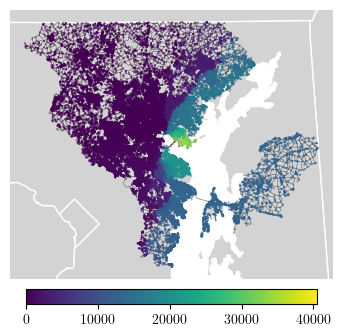

In [5]:
## map of the number of affected paths
fig, ax = plt.subplots()
fig.set_figwidth(MAP_WIDTH) # page width
fig.set_figheight(MAP_WIDTH*1.25)
ax.set_aspect('equal')
ax.axis('off')

# roads that weren't destroyed
edges.plot(
    color='dimgray',
    linewidth=0.25,
    zorder=5,
    ax=ax
)

# intersections
nodes.merge(
    right=spaths['u'].value_counts(),
    left_on='node',
    right_index=True,
    how='outer'
).replace(np.nan, 0).plot(
    column='count',
    cmap='viridis',
    markersize=0.05,
    zorder=10,
    legend=True,
    legend_kwds={
        'orientation': 'horizontal',
        'pad': 0.025,
        'shrink': 0.9
    },
    ax=ax
)

# bounds
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# add land
us_states.plot(
    facecolor='lightgray',
    edgecolor='white',
    zorder=0,
    ax=ax
)

# final things
ax.set_xlim(xlim) # keep bounds around baltimore
ax.set_ylim(ylim)
fig.tight_layout(pad=0)
folder = 'presentation' if present else 'paper'
if save: fig.savefig(f'{folder}/maps/no_changed_paths.png', dpi=400, bbox_inches='tight', pad_inches=0) # us png not pdf bc its a really big file

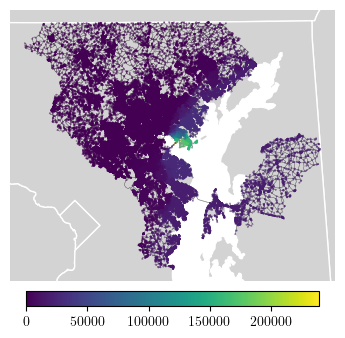

In [6]:
## map of the elgnths of affected paths
fig, ax = plt.subplots()
fig.set_figwidth(MAP_WIDTH) # page width
fig.set_figheight(MAP_WIDTH*1.25)
ax.set_aspect('equal')
ax.axis('off')

# roads that weren't destroyed
edges.plot(
    color='dimgray',
    linewidth=0.25,
    zorder=5,
    ax=ax
)

# intersections
nodes.merge(
    right=spaths[['u', 'diff_mi']].groupby('u').sum(),
    left_on='node',
    right_index=True,
    how='outer'
).replace(np.nan, 0).plot(
    column='diff_mi',
    cmap='viridis',
    markersize=0.05,
    zorder=10,
    legend=True,
    legend_kwds={
        'orientation': 'horizontal',
        'pad': 0.025,
        'shrink': 0.9
    },
    ax=ax
)

# bounds
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# add land
us_states.plot(
    facecolor='lightgray',
    edgecolor='white',
    zorder=0,
    ax=ax
)

# final things
ax.set_xlim(xlim) # keep bounds around baltimore
ax.set_ylim(ylim)
fig.tight_layout(pad=0)
folder = 'presentation' if present else 'paper'
if save: fig.savefig(f'{folder}/maps/dist_changed_paths.png', dpi=400, bbox_inches='tight', pad_inches=0) # us png not pdf bc its a really big file

In [7]:
## summaty stats
spaths['diff_mi'].describe()

count    4.749868e+08
mean     1.524582e+00
std      1.513785e+00
min      1.864118e-06
25%      5.586930e-01
50%      1.048577e+00
75%      2.017626e+00
max      1.571612e+01
Name: diff_mi, dtype: float64

/opt/miniconda3/envs/ox/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


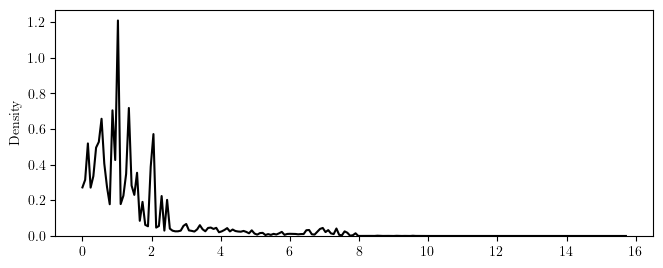

In [8]:
## Viz spath changes
fig, ax = plt.subplots()
fig.set_figwidth(6.5) # page width
fig.set_figheight(2.5)

sns.kdeplot(
    spaths['diff_mi'],
    color='black',
    cut=0,
    ax=ax
)

ax.set_xlabel('')
fig.tight_layout(pad=0)
folder = 'presentation' if present else 'paper'
if save: fig.savefig(f'{folder}/graphs/path_dists.pdf', bbox_inches='tight')